# Lead Scoring Model - Milestone 2
Predict lead quality using Random Forest

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Loading and Merging

In [17]:
data_path = os.path.join(os.getcwd(), "data", "original")

accounts_df = pd.read_csv(os.path.join(data_path, "accounts.csv"))
products_df = pd.read_csv(os.path.join(data_path, "products.csv"))
sales_pipeline_df = pd.read_csv(os.path.join(data_path, "sales_pipeline.csv"))
sales_teams_df = pd.read_csv(os.path.join(data_path, "sales_teams.csv"))

accounts_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
sales_pipeline_df.drop_duplicates(inplace=True)
sales_teams_df.drop_duplicates(inplace=True)

sales_pipeline_df['product'] = sales_pipeline_df['product'].replace("GTXPro", "GTX Pro")

df = (
    sales_pipeline_df
    .merge(sales_teams_df, on="sales_agent", how="left")
    .merge(products_df, on="product", how="left")
    .merge(accounts_df, on="account", how="left")
)

print(f"Shape: {df.shape}")
print(f"Deal stages: {df['deal_stage'].value_counts().to_dict()}")

Shape: (8800, 18)
Deal stages: {'Won': 4238, 'Lost': 2473, 'Engaging': 1589, 'Prospecting': 500}


## Data Preprocessing

In [18]:
df["engage_date"] = pd.to_datetime(df["engage_date"], errors="coerce")
df["close_date"] = pd.to_datetime(df["close_date"], errors="coerce")

categorical_cols = df.select_dtypes(include="object").columns
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in numerical_cols:
    if col not in ["close_value"]:
        df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.upper()

## Feature Engineering

In [19]:
df["has_close_date"] = df["close_date"].notna().astype(int)

for col in ["close_value", "revenue", "employees"]:
    df[col + "_log"] = np.log1p(df[col])

label_enc = LabelEncoder()
for col in ["sales_agent", "account", "office_location"]:
    df[col] = label_enc.fit_transform(df[col])

df = pd.get_dummies(df, columns=["product", "manager", "regional_office", "series", "sector", "subsidiary_of", "deal_stage"], drop_first=False, dtype=int)

scaler = StandardScaler()
df["sales_price_scaled"] = scaler.fit_transform(df[["sales_price"]])

df["year_established_decade"] = ((df["year_established"] // 10).astype(int) * 10).astype(str) + "s"
df = pd.get_dummies(df, columns=["year_established_decade"], prefix="decade", dtype=int)

df["engage_year"] = df["engage_date"].dt.year
df["engage_month"] = df["engage_date"].dt.month
df["engage_dayofweek"] = df["engage_date"].dt.dayofweek
df["days_to_close"] = (df["close_date"] - df["engage_date"]).dt.days
df["closed_within_30d"] = df["days_to_close"].apply(lambda x: 1 if pd.notnull(x) and x <= 30 else 0)

current_year = pd.Timestamp.now().year
df["account_age"] = current_year - df["year_established"]
df["rev_per_employee"] = df["revenue"] / df["employees"].replace(0, np.nan)

agent_closed_deals = df[df["close_date"].notnull()].groupby("sales_agent").size().rename("agent_closed_deals")
df = df.merge(agent_closed_deals, on="sales_agent", how="left")
df["agent_closed_deals"] = df["agent_closed_deals"].fillna(0)

df["won_deal"] = df["close_value"].notnull().astype(int)
win_rate = df.groupby("account")["won_deal"].mean().rename("account_win_rate")
df = df.merge(win_rate, on="account", how="left")

print(f"Final shape: {df.shape}")

Final shape: (8800, 71)


## Prepare Features and Target

In [20]:
target_col = "deal_stage_WON"
y = df[target_col]

drop_cols = [
    'opportunity_id', 'close_value', 'close_date', 'days_to_close',
    'closed_within_30d', 'close_value_log', 'won_deal', 'engage_date',
    'deal_stage_ENGAGING', 'deal_stage_LOST', 'deal_stage_PROSPECTING', 'deal_stage_WON'
]

X = df.drop(columns=[col for col in drop_cols if col in df.columns])

for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median() if X[col].dtype in ['float64', 'int64'] else 0)

print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Features: 59
Samples: 8800
Target distribution: {0: 4562, 1: 4238}


## Train/Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 7040, Test: 1760


## Model Training - Random Forest

In [22]:
print("Training Random Forest...")

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"ROC-AUC:        {roc_auc:.4f}")

Training Random Forest...

Train Accuracy: 0.9955
Test Accuracy:  0.6739
Precision:      0.6359
Recall:         0.7559
F1-Score:       0.6907
ROC-AUC:        0.7351


## Model Evaluation

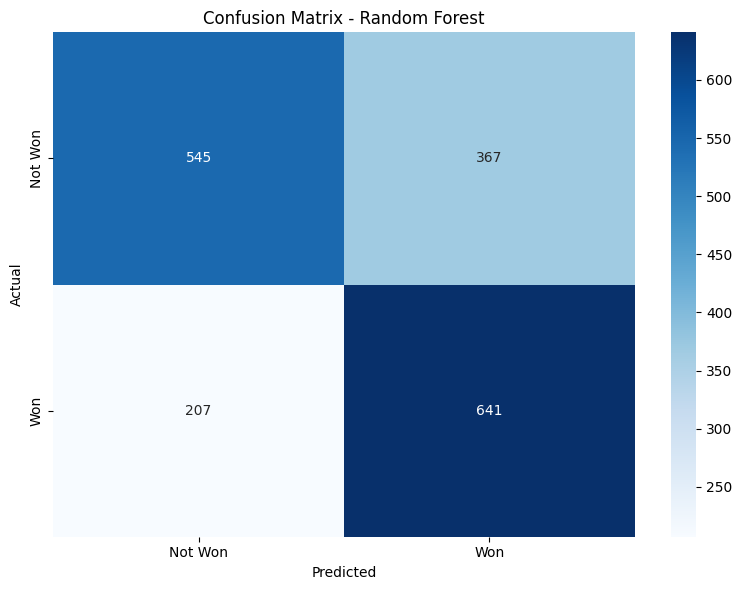


Classification Report:
              precision    recall  f1-score   support

     Not Won       0.72      0.60      0.66       912
         Won       0.64      0.76      0.69       848

    accuracy                           0.67      1760
   macro avg       0.68      0.68      0.67      1760
weighted avg       0.68      0.67      0.67      1760



In [23]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Won', 'Won'], yticklabels=['Not Won', 'Won'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Not Won', 'Won']))

## Feature Importance

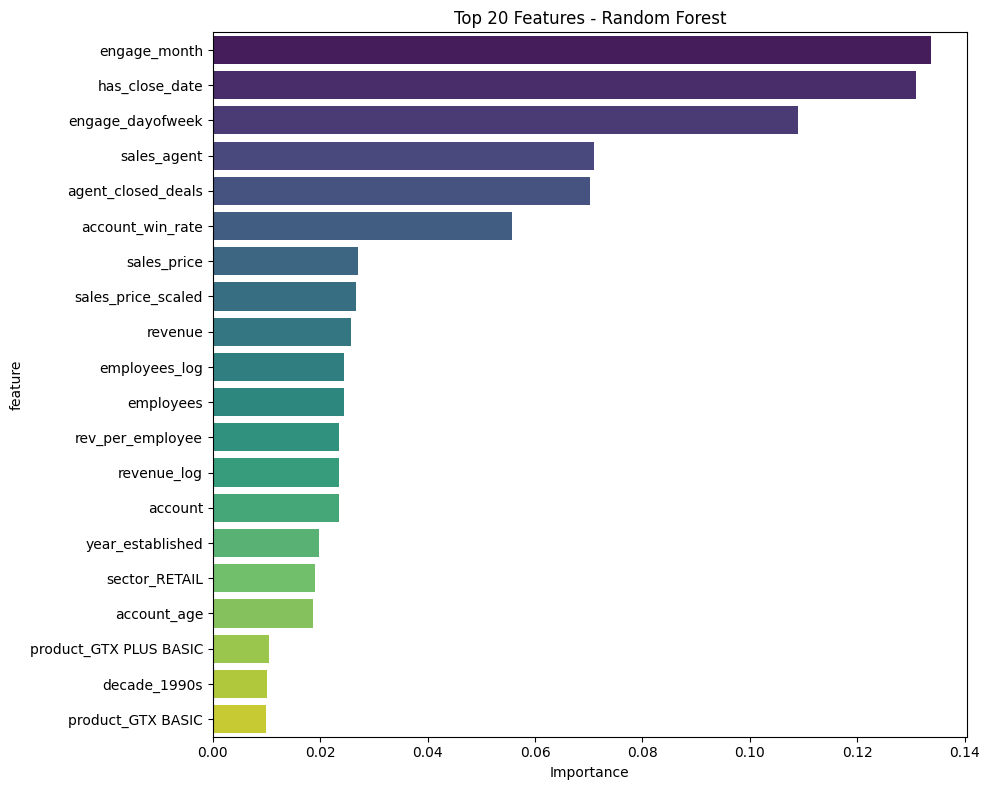


Top 10 Features:
           feature  importance
      engage_month    0.133700
    has_close_date    0.130883
  engage_dayofweek    0.108885
       sales_agent    0.070967
agent_closed_deals    0.070271
  account_win_rate    0.055806
       sales_price    0.026975
sales_price_scaled    0.026574
           revenue    0.025800
     employees_log    0.024513


In [24]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Features - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

## Save Model

In [25]:
import joblib

model_path = os.path.join(os.getcwd(), "models")
os.makedirs(model_path, exist_ok=True)

model_filename = os.path.join(model_path, "lead_scoring_model.pkl")
joblib.dump(model, model_filename)
print(f"Model saved to: {model_filename}")

feature_names_file = os.path.join(model_path, "feature_names.pkl")
joblib.dump(X.columns.tolist(), feature_names_file)
print(f"Feature names saved to: {feature_names_file}")

Model saved to: /Users/mjamm/Desktop/Team2A/models/lead_scoring_model.pkl
Feature names saved to: /Users/mjamm/Desktop/Team2A/models/feature_names.pkl
